In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.cm import get_cmap

import pickle
import math
import numpy as np
import random

from scipy.interpolate import interp1d

In [2]:
from IPython.display import clear_output
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [3]:
os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /home/junhyug/SPOC_active_learning


In [4]:
from builder import build_dataset
from utils import config_util

In [5]:
result_dir = "./results"
data_name = "polymer_v4"
material = None # [LiTFSI, NaTFSI]
print_type = 'PCB' # [PCB, coin]

In [6]:
base_path = os.path.join(result_dir, "_".join([str(value).upper() for value in (data_name, material, print_type) if value is not None]))
print(base_path)
os.path.exists(base_path)

./results/POLYMER_V4_PCB


True

## Get Experiments

In [7]:
model = 'RANDOM_FOREST' # 'GAUSSIAN_PROCESS', 'RANDOM_FOREST'
param = None # Kernel or N_BASE
acq = None # [None, 'EI', 'LCB', 'PI']
top_ratio = '0.1'
tag = None

def exp_formatter(model, param, acq):
    return f"{model} ({param} / {acq})"

def parse_directory_name(directory_name):
    """
    Parse the directory name based on the expected naming convention
    and return the components.
    """
    parts = directory_name.split('-')
    if len(parts) < 5:
        return None  # Ensure there are enough parts to parse correctly
    
    model = parts[0]
    others = parts[-1].split('_')
    if len(others) < 3:
        return None
    
    param = others[0]
    acq = others[1]
    ratio = others[2]
    
    return model, param, acq, ratio

abbr_dict = {
    "RANDOM_FOREST": "RF",
    "GAUSSIAN_PROCESS": "GP",
}

def find_directories(base_path, model=None, param=None, acq=None, ratio=None, tag=None):
    """
    List and filter directories based on provided n_base, acq, and ratio.
    """
    all_items = os.listdir(base_path)
    directories = [item for item in all_items if os.path.isdir(os.path.join(base_path, item))]
    
    result_dict = {}
    for dir_name in directories:
        if tag is not None:
            if not tag in dir_name:
                continue
        parsed = parse_directory_name(dir_name)
        if parsed:
            parsed_model, parsed_param, parsed_acq, parsed_ratio = parsed
            if ((model is None or parsed_model == model) and
                (param is None or parsed_param == param) and
                (acq is None or parsed_acq == acq) and 
                (ratio is None or parsed_ratio == ratio)):
                # key = f"{parsed_model} ({parsed_param} / {parsed_acq})"
                key = exp_formatter(abbr_dict[parsed_model], parsed_param, parsed_acq)
                result_dict[key] = dir_name
    
    return result_dict


exp_names = find_directories(base_path, model=model, param=param, acq=acq, ratio=top_ratio, tag=tag)
exp_names = {key: exp_names[key] for key in sorted(exp_names)}

for key, directory in exp_names.items():
    print(f"{key}: {directory}")

RF (100 / EI): RANDOM_FOREST-20250223-181717-mx2cu1_q-100_EI_0.1
RF (100 / LCB): RANDOM_FOREST-20250223-183649-iq4i8gj9-100_LCB_0.1
RF (100 / PI): RANDOM_FOREST-20250223-182658-ah8zaqkt-100_PI_0.1
RF (25 / EI): RANDOM_FOREST-20250223-180753-cu0v8srw-25_EI_0.1
RF (25 / LCB): RANDOM_FOREST-20250223-183147-b9f8qxfp-25_LCB_0.1
RF (25 / PI): RANDOM_FOREST-20250223-182159-8f42zcs3-25_PI_0.1
RF (50 / EI): RANDOM_FOREST-20250223-181334-tirr7w5_-50_EI_0.1
RF (50 / LCB): RANDOM_FOREST-20250223-183351-923acwst-50_LCB_0.1
RF (50 / PI): RANDOM_FOREST-20250223-182359-t0s5alax-50_PI_0.1


In [8]:
exp_results = {}
for exp_name, exp_dir_name in exp_names.items():
    exp_dir = os.path.join(base_path, exp_dir_name)
    exp_path = os.path.join(exp_dir, "results.pickle")
    configs = config_util.load_configs(os.path.join(exp_dir, "configs.yaml"))
    with open(exp_path, "rb") as f:
        results = pickle.load(f)
        
    exp_results[exp_name] = {
        "path": exp_path,
        "configs": configs,
        "exp_indices": results["exp_indices"],
        "top_counts": results["top_counts"],
        "total_tile": results["total_time"],
    }

In [9]:
idx = 0
exp_name = list(exp_results.keys())[idx]
configs = exp_results[exp_name]["configs"]
configs

{'data': {'name': 'polymer_v4', 'material': None, 'print_type': 'PCB'},
 'model': {'name': 'random_forest',
  'params': {'n_estimators': 100, 'n_jobs': -1}},
 'train': {'n_seeds': 500,
  'n_initial': 2,
  'top_ratio': 0.1,
  'scaler': 'standard',
  'acquisition': 'EI'}}

In [10]:
dataset = build_dataset(configs["data"])
dataset.df

[2025-04-09 15:36:06,731] Preprocess dataset..
[2025-04-09 15:36:06,733]  - Shape (Before): (1300, 5)
[2025-04-09 15:36:06,734]  - Categorical (2) / Numerical (3)
[2025-04-09 15:36:06,750]  - Shape (After) : (90, 6)


fcomp_additive_wt_pct  fcomp_salt_wt_pct  material_LiTFSI  \
0                     0.0                0.0              0.0   
1                     0.0                0.0              1.0   
2                     0.0                2.9              0.0   
3                     0.0                4.3              1.0   
4                     0.0                5.7              0.0   
..                    ...                ...              ...   
85                   15.0               17.0              1.0   
86                   15.0               20.0              1.0   
87                   15.0               21.0              1.0   
88                   15.0               26.0              1.0   
89                   15.0               30.0              1.0   

    material_NaTFSI  print_type_PCB  ionic_conductivity_final  
0               1.0             1.0             -5.927169e-07  
1               0.0             1.0             -4.243117e-07  
2               1.0             1.0             -1.302684e-06  
3               0.0             1.0             -2.739800e-06  
4               1.0             1.0             -1.614583e-06  
..              ...             ...                       ...  
85              0.0             1.0             -2.365138e-06  
86              0.0             1.0             -3.691816e-06  
87              0.0             1.0             -5.751356e-06  
88              0.0             1.0             -5.710516e-06  
89              0.0             1.0             -2.660974e-06  

[90 rows x 6 columns]

In [11]:
N = len(dataset)
top_indices = dataset.get_top_indices(ratio=float(top_ratio))
n_top = len(top_indices)
print(N, n_top)

90 9


In [12]:
np.random.seed(22)
seeds = np.random.choice(
    range(10000), size=configs["train"]["n_seeds"], replace=False
)
print(seeds)

[2077 9207 6755 6704 9528 7421 2578 9479 2176 8572 7084 7941 4027 6406
 3909 3945 7099 3108 3141 4752 6055 4126 7911  779 7665 6400 5245  926
 8549 8610 7828 2861 7417 2548 3135 7477 5972 1581 8540 9154  199 9473
 7502 5536 6872 8405 9702 5720  450 3892 3204 5642 2447 3159 5439 9145
 3768 1729 3170 9706 3233 5778 9602 5616 4837 7000 5993 5693 9049 8396
 8972 6358 6380 2666 5538 6263 2814 8363 1717 5579 3536 5278 1884 2408
 5534 7025   86 3206 3014 4325 6766  157 4733 5729 2570 8061 4641 2793
 9075 2677 1946  835 5831 4851 4232  219 5208 1659 5792 6215 8112 2996
  666  134 1647 1083 8982 2689 6774 9525  783 1738 8385 5563 9709 1887
 9270 5802 6731 6499  833 3591 9348 7400 4621 4634 6075 5717 3953 4556
 6148 8534 2856 5851 1332 1211 4215 7768 6969 6191 1270   62 9649 8309
 9686 7923 8494 4016 4021 1054 2402 2334 7674 7897 4653 4496 8609 8833
  378 1343 2136 5329 3800 2518 8806 9175 1207  804 8134 9012 3523 5966
  941  522 4427 5173 6990 3119 2876 8104  611 7998 5546  910 7143 6653
 1844 

## Random Baseline

In [13]:
def P_rand(nn):
    x_random = np.arange(nn)
    
    M = n_top
    N = nn
    
    P = np.array([None for i in x_random])
    E = np.array([None for i in x_random])
    A = np.array([None for i in x_random])
    cA = np.array([None for i in x_random])
    
    P[0] = M / N
    E[0] = M / N
    A[0] = M / N
    cA[0] = A[0]
    
    for i in x_random[1:]:
        P[i] = (M - E[i-1]) / (N - i)
        E[i] = np.sum(P[:(i+1)])
        j = 0
        A_i = P[i]
        while j < i:
            A_i *= (1 - P[j])
            j+=1
        A[i] = A_i
        cA[i] = np.sum(A[:(i+1)])
        
    return E / M, cA

## Aggregation of Performance

In [14]:
def aggregation_(seed, n_runs, n_fold):
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    random.seed(seed)
    index_runs = list(np.arange(n_runs))
    agg_list = []
    
    i = 0
    while i < n_fold:
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
        agg_list.append(index_i)
        i += 1
    return agg_list

def avg_(x):
    n_eval = len(x[0]) 
    n_fold = 5
    n_runs = len(x)
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    n_sets = len(seeds)
    l_index_list = []
    
    for i in np.arange(n_sets):
        s = aggregation_(seeds[i], n_runs, n_fold)
        l_index_list.extend(s)

    assert len(l_index_list) == n_sets * n_fold

    l_avg_runs = []
    for i in np.arange(len(l_index_list)):
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            avg_run += np.array(x[j])
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    
    assert n_eval == len(l_avg_runs[0])
    assert n_sets * n_fold == len(l_avg_runs)
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    
    # 5th, 95th percentile, mean, median are all accessible
    for i in np.arange(len(l_avg_runs[0])):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.05, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.95, out=None, overwrite_input=False, interpolation='linear')
    
    return np.array(median_), np.array(low_q), np.array(high_q), np.array(mean_), np.array(std_)

# Top%

In [15]:
def TopPercent(x_top_count, n_top, N):
    x_ = [[] for i in np.arange(len(x_top_count))]
    for i in np.arange(len(x_top_count)):
        for j in np.arange(N):
            if j < len(x_top_count[i]):
                x_[i].append(x_top_count[i][j] / n_top)
            else:
                x_[i].append(1)
    return x_

In [16]:
# Aggregating the performance
top_percents = {exp_name: avg_(TopPercent(results["top_counts"], n_top, N)) for exp_name, results in exp_results.items()}

In [17]:
fontsize = 30
dpi = 600

num_colors = len(top_percents)
color_map = get_cmap('Accent')  # Choose a colormap that can provide sufficient distinct colors
colors = [color_map(i / num_colors) for i in range(num_colors)]

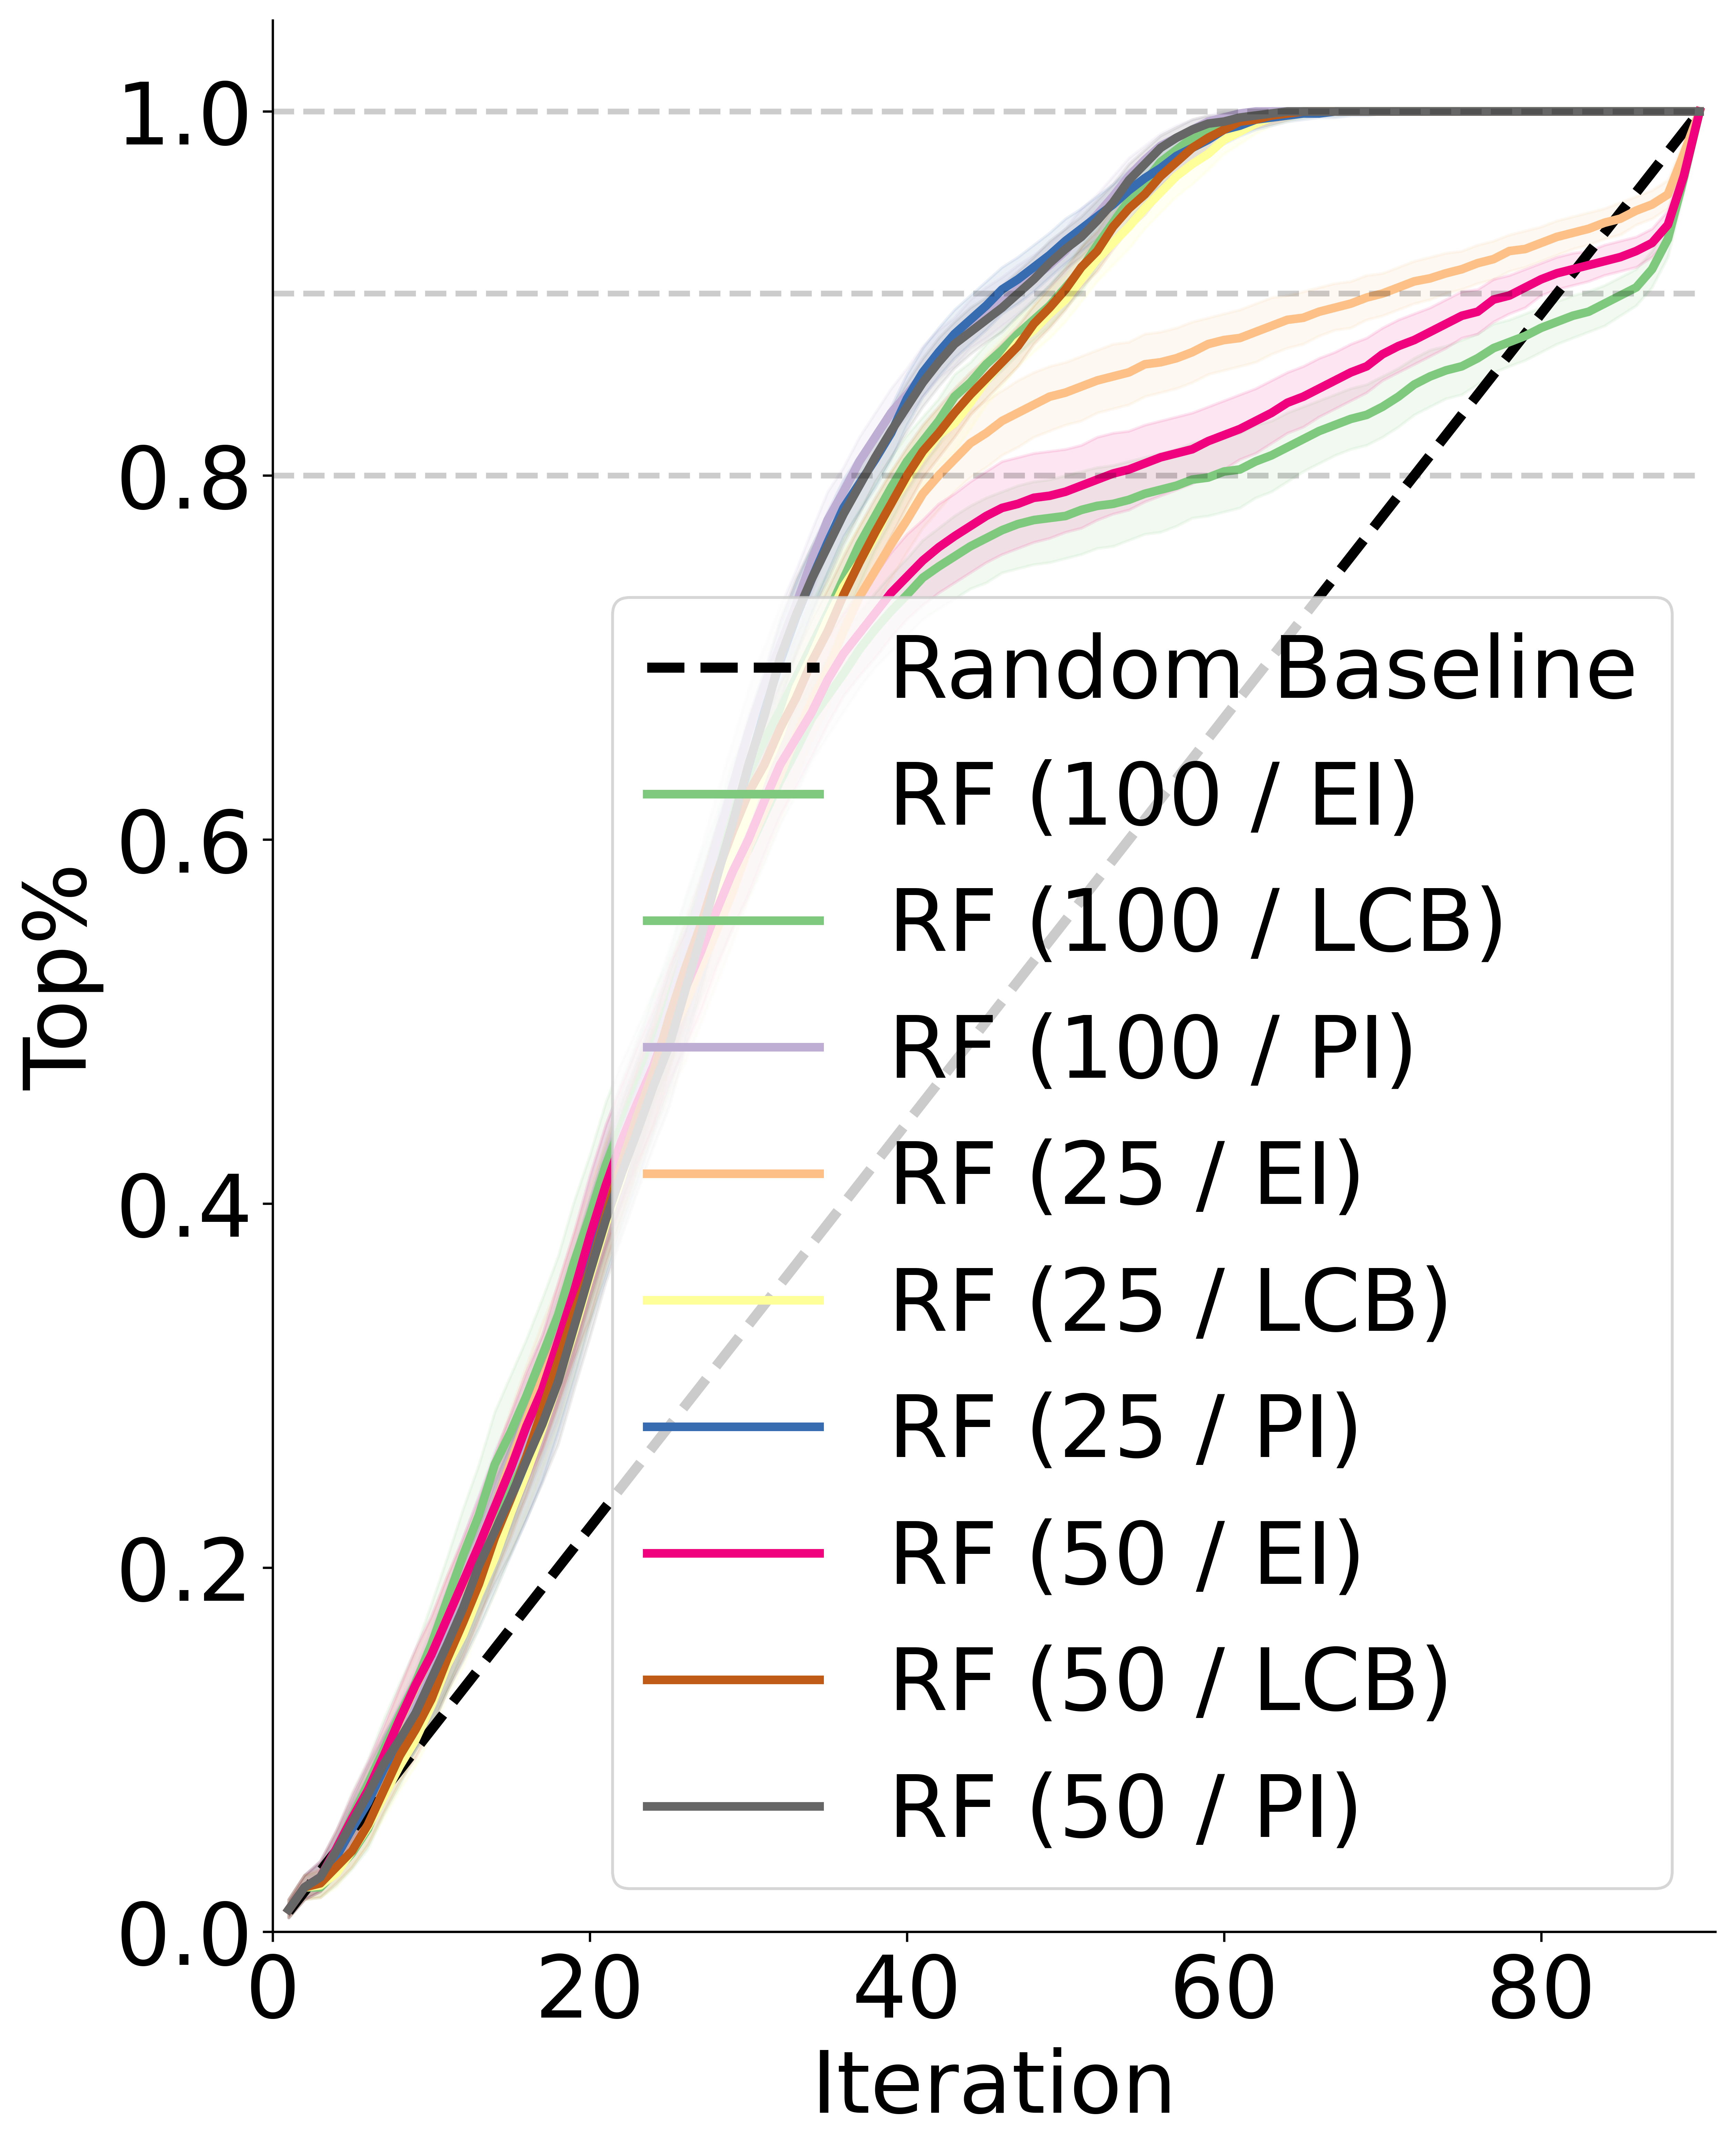

In [18]:
# Creating plot
fig = plt.figure(figsize=(9, 12), dpi=dpi)
ax0 = fig.add_subplot(111)

# Plotting a baseline for reference
ax0.plot(np.arange(N)+1, P_rand(N)[0],'--',color='black',label='Random Baseline', linewidth=3.5)

# Plotting experiments
for i, (exp_name, top_percent) in enumerate(top_percents.items()):
    label = exp_name
    ax0.plot(np.arange(N) + 1, top_percent[0], label=label, color=colors[i], linewidth=3)
    ax0.fill_between(np.arange(N) + 1, top_percent[1], top_percent[2], color=colors[i], alpha=0.1)

# Additional plot settings
ax0.set_ylabel("Top%", fontsize=fontsize, rotation='vertical')
plt.hlines(0.8, 0, N, colors='k', linestyles='--', alpha=0.2, lw=2)
plt.hlines(0.9, 0, N, colors='k', linestyles='--', alpha=0.2, lw=2)
plt.hlines(1.0, 0, N, colors='k', linestyles='--', alpha=0.2, lw=2)
ax0.set_ylim([0, 1.05])
ax0.set_xlim([0, N+1])
ax0.set_xlabel('Iteration', fontsize=fontsize)
ax0.xaxis.set_tick_params(labelsize=fontsize)
ax0.yaxis.set_tick_params(labelsize=fontsize)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

# Adjusting the legend location
ax0.legend(loc='lower right', fontsize=fontsize, frameon=True)

plt.show()

## EF

In [19]:
def EF(x):
    n_eval = len(x)
    TopPercent_RS = P_rand(n_eval)[0]
    
    l_EF = []
    for j in np.arange(n_eval):
        l_EF.append(x[j] / TopPercent_RS[j])
        
    return l_EF

RF (100 / EI) 1.8249999999999984
RF (100 / LCB) 1.9068965517241365
RF (100 / PI) 1.9942857142857118
RF (25 / EI) 1.7911764705882336
RF (25 / LCB) 1.8636363636363618
RF (25 / PI) 1.969696969696968
RF (50 / EI) 1.8068965517241364
RF (50 / LCB) 1.8766666666666652
RF (50 / PI) 1.972727272727271


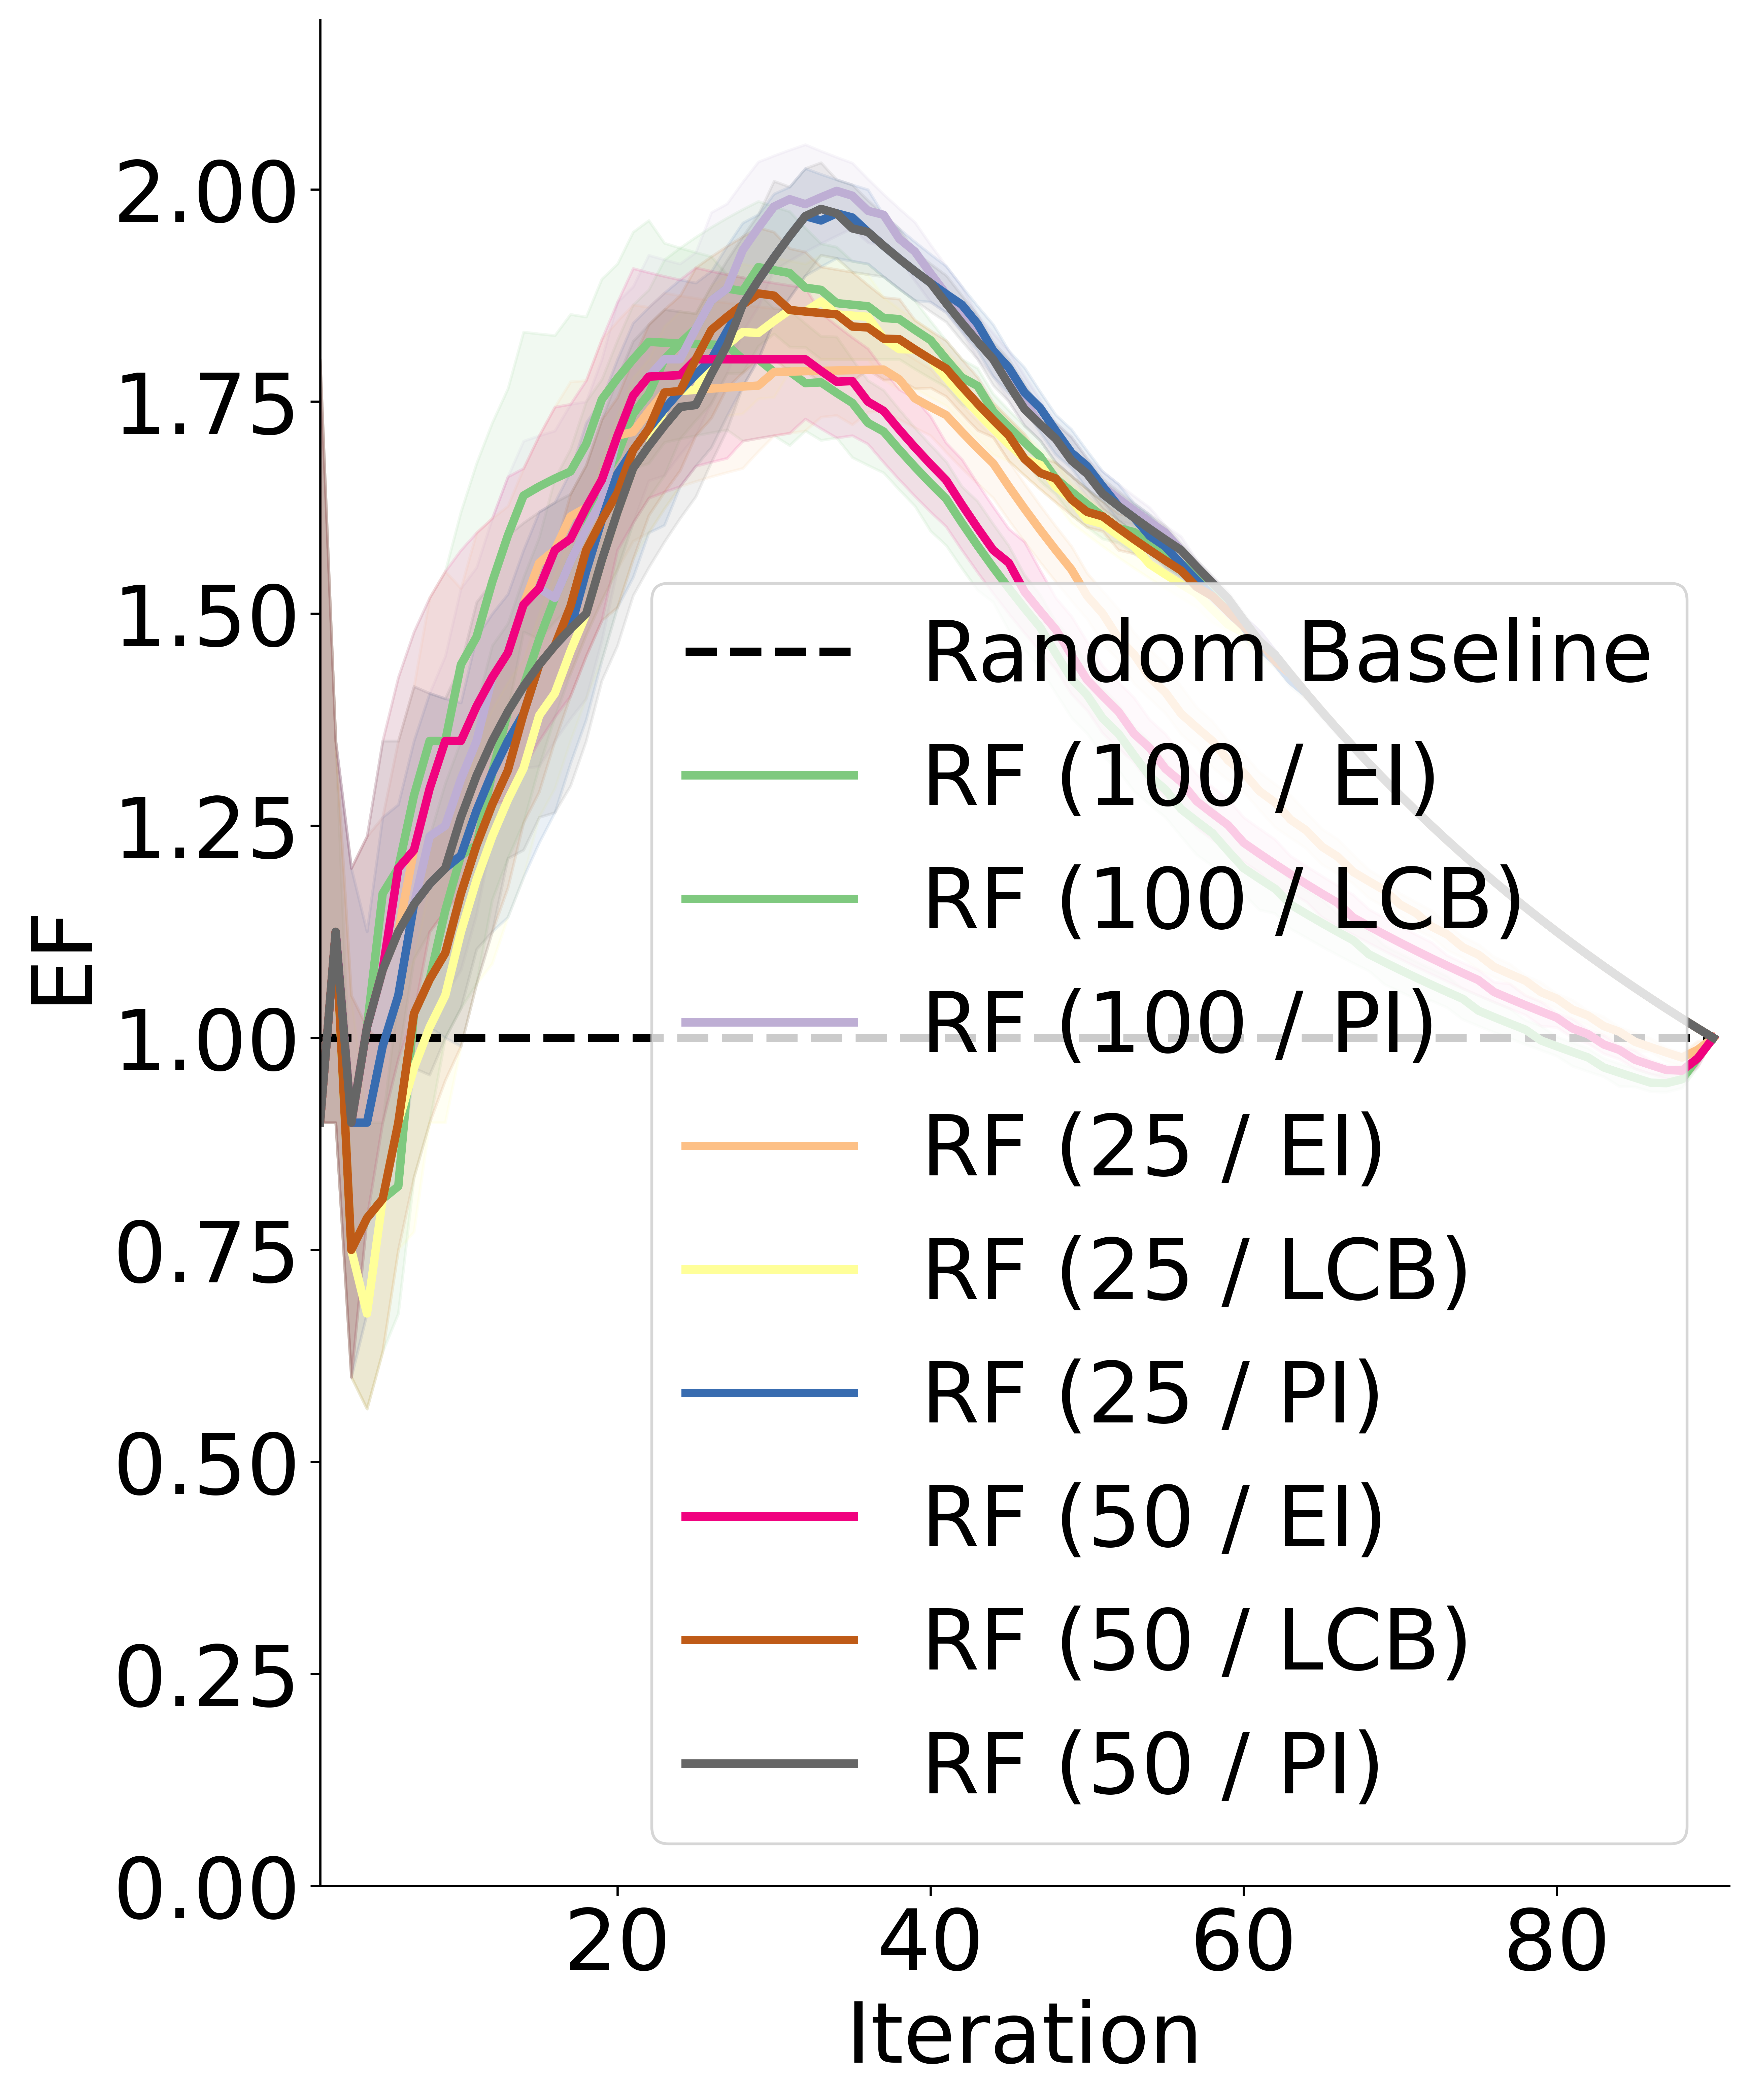

In [20]:
# Creating plot
fig = plt.figure(figsize=(9, 12), dpi=dpi)
ax0 = fig.add_subplot(111)

# Plotting a baseline for reference
ax0.plot(np.linspace(1, N, N), np.ones(N),'--',color='black',label='Random Baseline', linewidth = 3)        

# Plotting experiments
for i, (exp_name, top_percent) in enumerate(top_percents.items()):
    label = exp_name
    f_med_ef = EF(top_percent[0].astype(np.double))
    ax0.plot(np.arange(N) + 1, EF(np.round(top_percent[0].astype(np.double) / 0.005, 0) * 0.005), label=label, color=colors[i], linewidth=3)
    ax0.fill_between(np.arange(N) + 1, EF(np.round(top_percent[1].astype(np.double) / 0.005, 0) * 0.005), EF(np.round(top_percent[2].astype(np.double) / 0.005, 0) * 0.005), color=colors[i], alpha=0.1)
    print(exp_name, max(f_med_ef))

# the rest are for visualization purposes, please adjust for different needs
ax0.legend(loc='lower right', fontsize=fontsize, frameon=True) #, bbox_to_anchor=(0.01, 0.98))  # Adjusted here

ax0.set_ylabel('EF', fontsize=fontsize, rotation='vertical')
ax0.set_xlabel('Iteration', fontsize=fontsize)
ax0.set_xlim([1, N+1])
ax0.set_ylim([0, 2.2])
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.xaxis.set_tick_params(labelsize=fontsize)
ax0.yaxis.set_tick_params(labelsize=fontsize)

## AF

In [21]:
interval = 1./64.
n_bins = int(1./interval)

TOL = 1e-5

# Function to check if x is in L within a tolerance
def is_close_in_list(x, L, abs_tol=TOL):
    return any(math.isclose(x, elem, abs_tol=abs_tol) for elem in L)

def AF(top_percent):

    n_iters = len(top_percent)

    iterations = list(range(1, n_iters + 1))
    top_percent_rs = P_rand(n_iters)[0]
    
    interp_top = interp1d(top_percent, iterations, kind='linear', fill_value="extrapolate")
    interp_top_rs = interp1d(top_percent_rs, iterations, kind='linear', fill_value="extrapolate")
    
    combined_top = list(np.union1d(top_percent, top_percent_rs))
    
    iter_interp = interp_top(combined_top)
    iter_interp_rs = interp_top_rs(combined_top)

    af = iter_interp_rs / iter_interp

    return combined_top, af

def AF_interp1d(TopPercent):
    x_low, y_low = AF(TopPercent[1])
    x_high, y_high = AF(TopPercent[2])

    # Create a combined x array (union of all x values)
    combined_x = np.union1d(x_low, x_high)
    
    # Interpolate y values for these new x values
    interp_low = interp1d(x_low, y_low, kind='linear', fill_value="extrapolate")
    interp_high = interp1d(x_high, y_high, kind='linear', fill_value="extrapolate")
    
    y_low_new = interp_low(combined_x)
    y_high_new = interp_high(combined_x)

    return combined_x, y_low_new, y_high_new

RF (100 / EI) 1.824999999999999
RF (100 / LCB) 1.9068965517241385
RF (100 / PI) 1.9942857142857129
RF (25 / EI) 1.7911764705882351
RF (25 / LCB) 1.8636363636363633
RF (25 / PI) 1.9696969696969697
RF (50 / EI) 1.8068965517241382
RF (50 / LCB) 1.8766666666666667
RF (50 / PI) 1.9727272727272729


(0.0, 2.2)

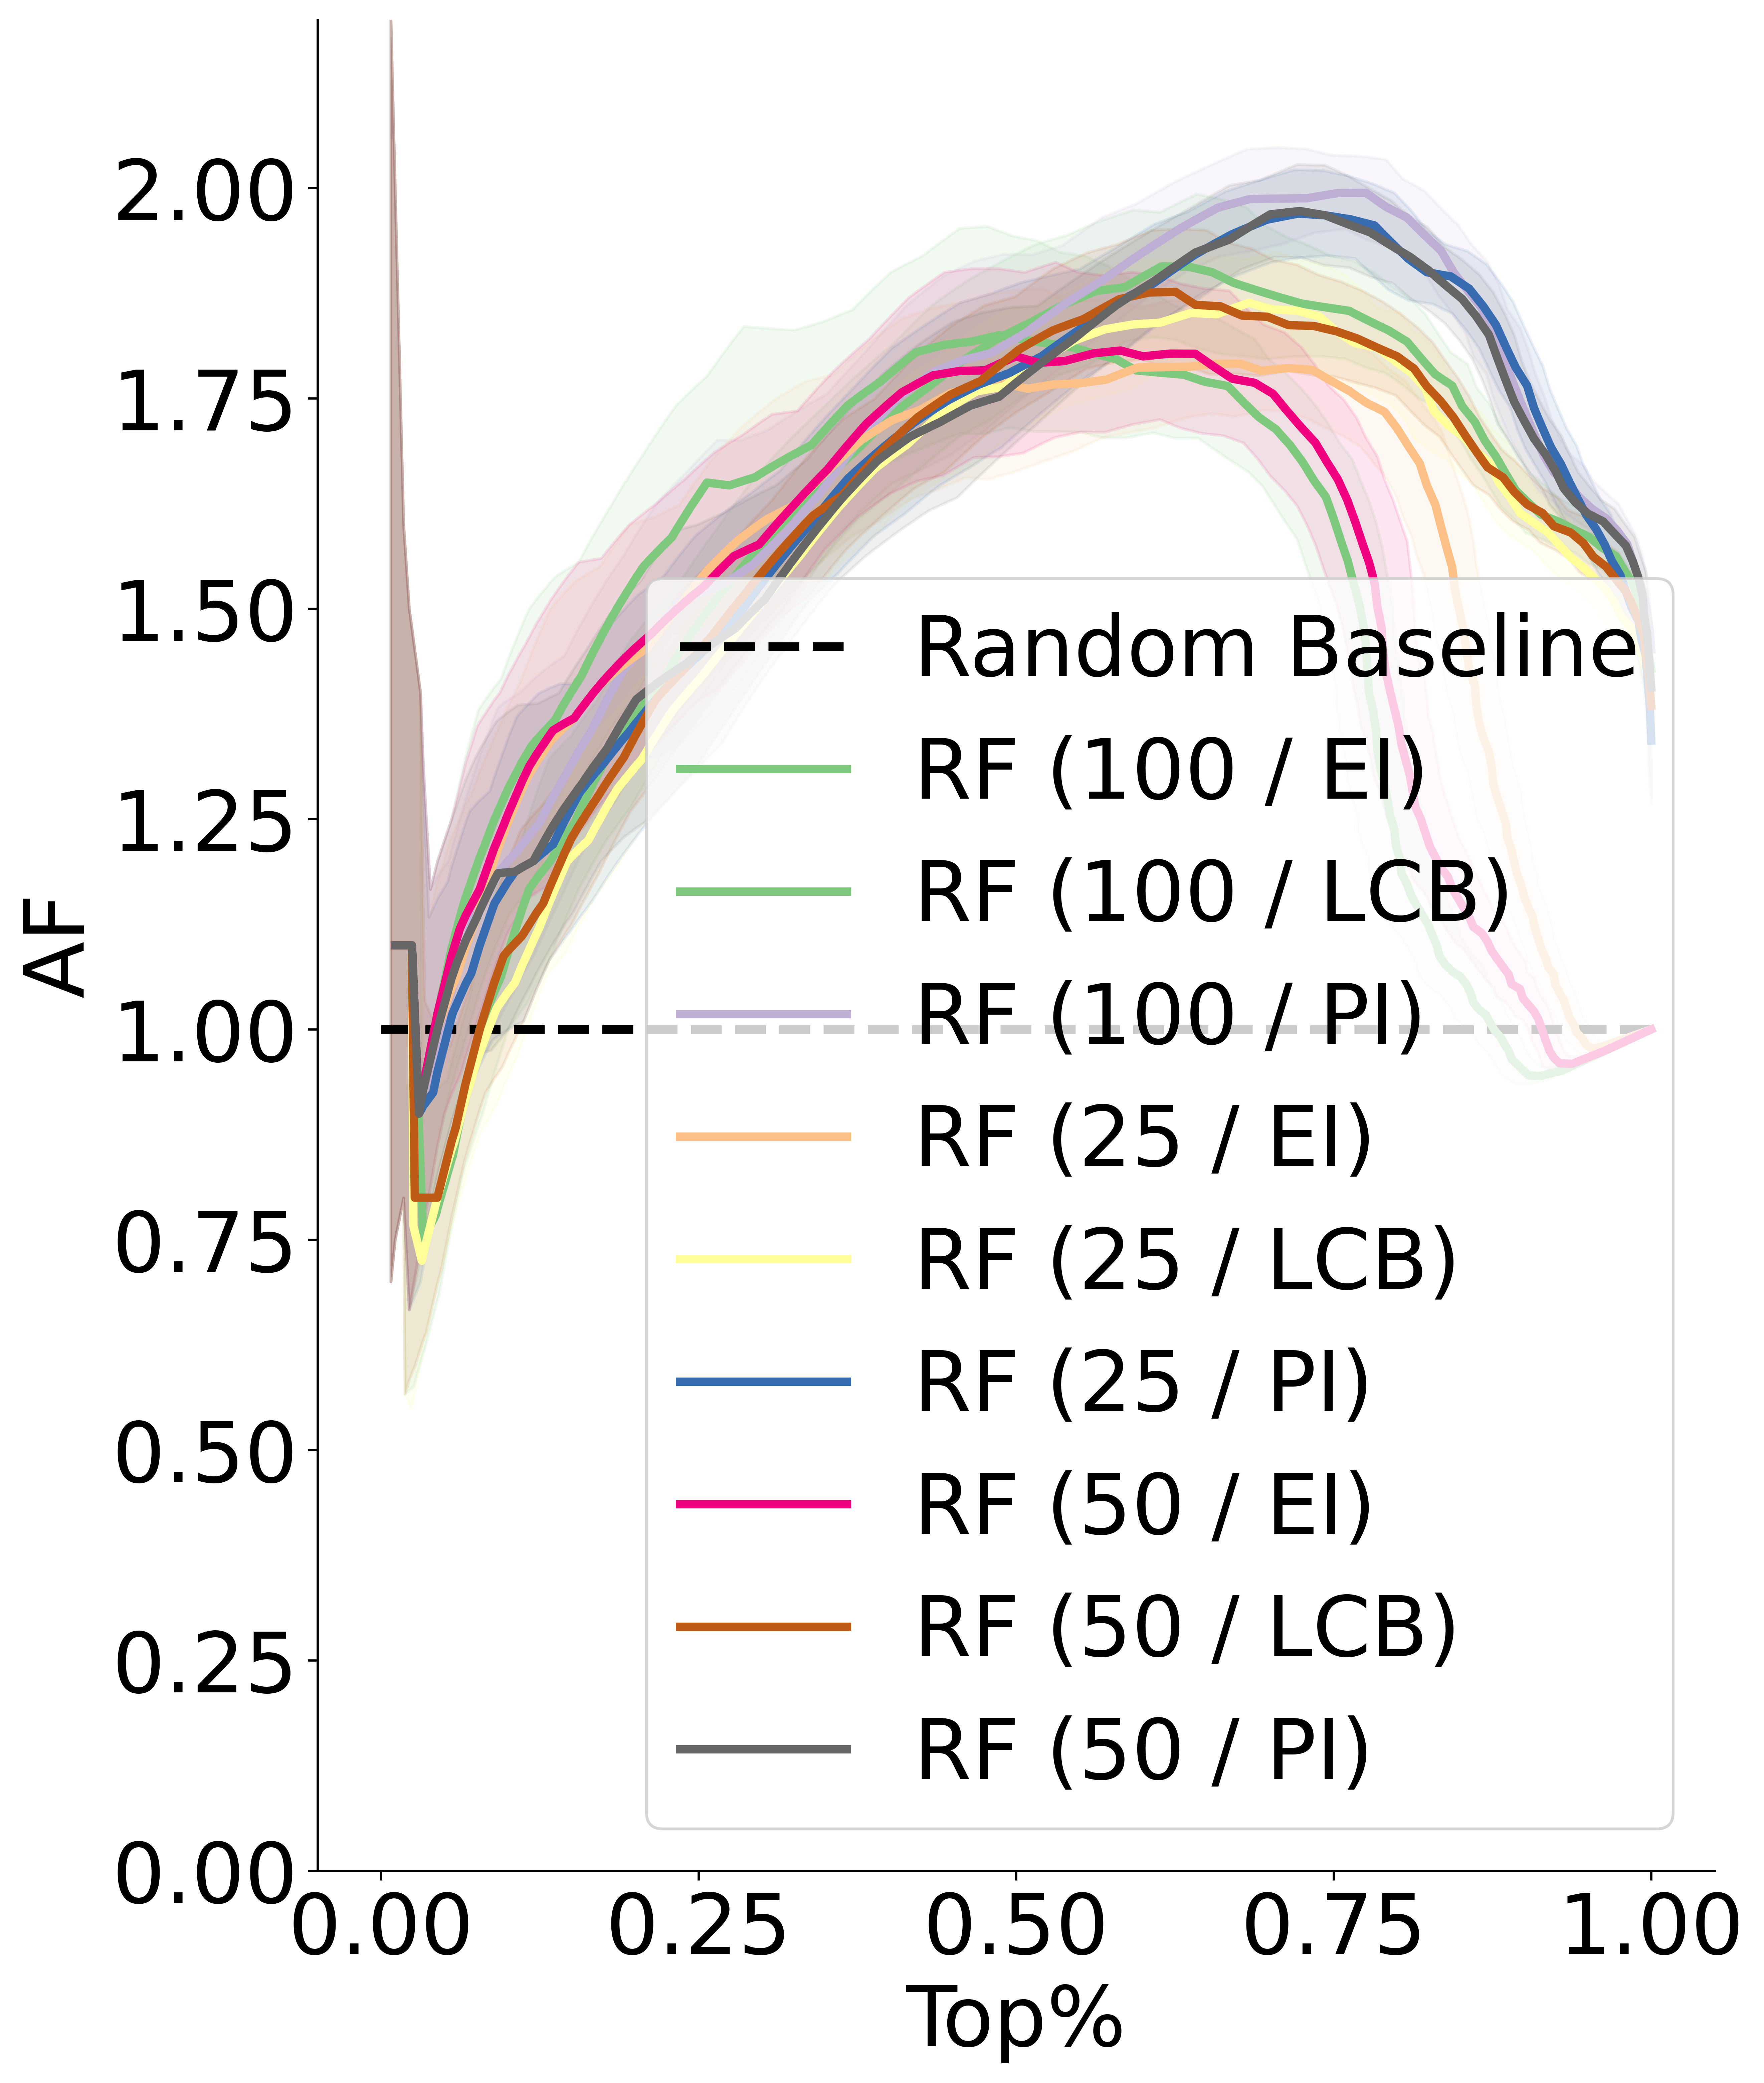

In [22]:
# Creating plot
fig = plt.figure(figsize=(9, 12), dpi=dpi)
ax0 = fig.add_subplot(111)

# Plotting a baseline for reference
ax0.plot(np.linspace(0, 1, n_bins), np.ones(n_bins),'--',color='black',label='Random Baseline', linewidth = 3) 

# Plotting experiments
for i, (exp_name, top_percent) in enumerate(top_percents.items()):
    label = exp_name
    f_med_top, f_med_af = AF(top_percent[0])
    ax0.plot(f_med_top, f_med_af, label=label, color=colors[i], linewidth=3)
    _x, _y_low, _y_high = AF_interp1d(top_percent)
    ax0.fill_between(_x, _y_low, _y_high, color=colors[i], alpha=0.1)
    print(exp_name, f_med_af.max())

# the rest are for visualization purposes, please adjust for different needs
ax0.legend(loc='lower right', fontsize=fontsize, frameon=True)
ax0.set_ylabel('AF', fontsize=fontsize, rotation='vertical')
ax0.set_xlabel('Top%', fontsize=fontsize)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.xaxis.set_tick_params(labelsize=fontsize)
ax0.yaxis.set_tick_params(labelsize=fontsize)
ax0.set_ylim([0, 2.2])  # Adjust the values as needed